# Carve up 2+1D Spatiotemporal Space with Oriented Gabors

Now, define filters with a 3rd dimension!

In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
pi = np.pi

def gauss_filter_3d(x, y, z, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, norm=True):
    response = np.exp(-((x - mu_x)**2 / (2 * sigma_x**2) + 
                        (y - mu_y)**2 / (2 * sigma_y**2) + 
                        (z - mu_z)**2 / (2 * sigma_z**2)))
    if norm:
        response = response / ((sigma_x * sigma_y * sigma_z) * (2 * np.pi)**1.5)
    return response

def pol2cart3d(rho, phi, theta):
    x = rho * np.sin(theta) * np.cos(phi)
    y = rho * np.sin(theta) * np.sin(phi)
    z = rho * np.cos(theta)
    return x, y, z

def cart2pol3d(x, y, z):
    #rho = np.sqrt(x**2 + y**2 + z**2)
    #theta = np.arccos(z / rho)
    #phi = np.arctan2(y, x)
    rho = magnitude(x, y, z)
    theta = np.arctan2(sqrt(x * x + y * y), z)
    phi = np.arctan2(y, x)
    return rho, theta, phi

def polar_gaussian_3d(xs, ys, zs, scale, orientation, elevation, phase_offset=0, norm=False):
    mu_x, mu_y, mu_z = pol2cart3d(scale, orientation, elevation)
    scaling_factor = 0.4
    filt_sigma = scale * scaling_factor
    filt = gauss_filter_3d(xs, ys, zs, mu_x, mu_y, mu_z, filt_sigma, filt_sigma, filt_sigma, norm=norm)
    filt = filt * np.exp(1j * phase_offset)
    return filt

def quadrature_gaussian_filter_3d(xs, ys, zs, scale, orientation, elevation, norm=True, separate_pairs=False):
    filter_real = polar_gaussian_3d(xs, ys, zs, scale, orientation, elevation, phase_offset=0, norm=True)
    filter_imag = polar_gaussian_3d(xs, ys, zs, scale, orientation + np.pi, np.pi-elevation, phase_offset=np.pi/2, norm=True)
    if(separate_pairs):
        filter = (filter_real, 1j*filter_imag)
    else:
        filter = filter_real + 1j*filter_imag
    return filter

## Plot a Demo

First a scatterplot

(-2.0, 2.0)

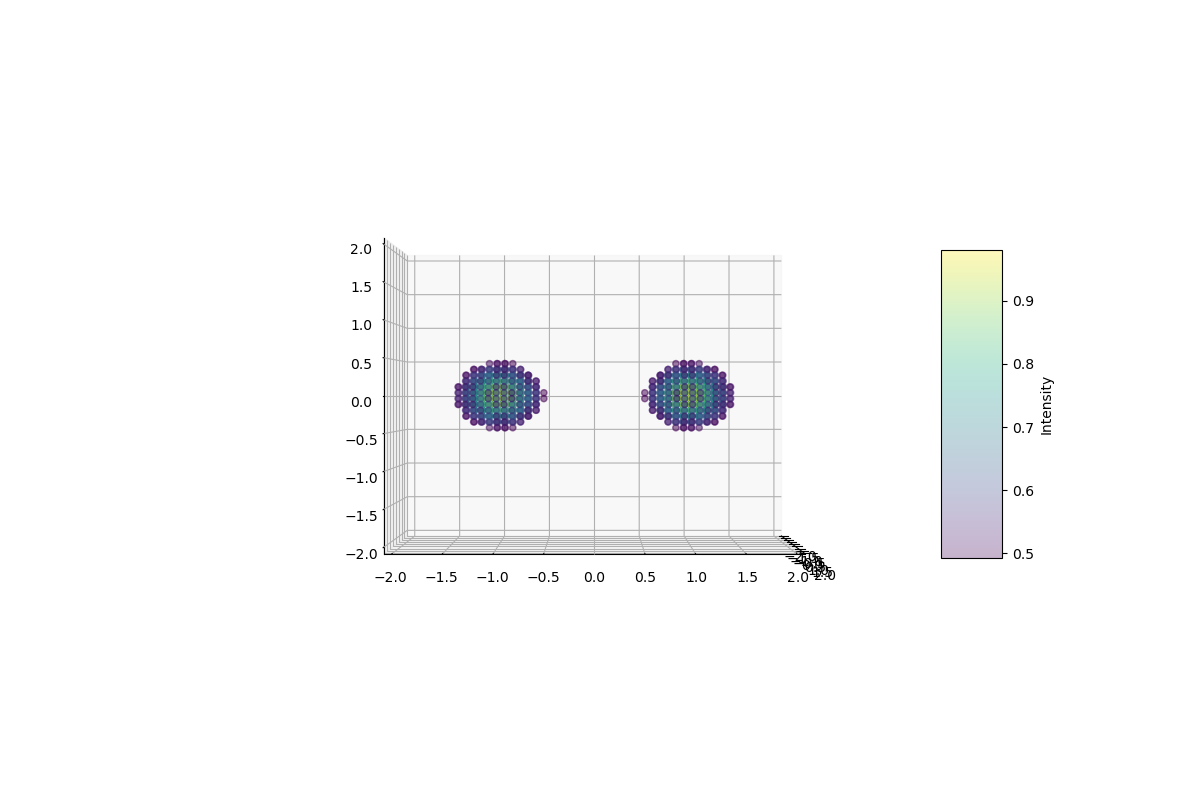

In [2]:
def plot_3d_quadrature_gaussian_filter(scale, orientation, elevation, space=np.linspace(-5, 5, num=50)):
    xs, ys, zs = np.meshgrid(space, space, space)
    
    filter = quadrature_gaussian_filter_3d(xs, ys, zs, scale, orientation, elevation, norm=True, separate_pairs=False)
    filter_amplitude = np.abs(filter)
    max_amplitude = np.max(filter_amplitude)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.view_init(0, 0, 0)

    #filter_amplitudes_normed = filter_amplitude / max_amplitude
    keep_mask = np.where(filter_amplitude > (max_amplitude/2))
    
    scatter = ax.scatter(xs[keep_mask], ys[keep_mask], zs[keep_mask], c=filter_amplitude[keep_mask], cmap='viridis', marker='o', alpha=0.3)
    
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Intensity')

    return(ax)

scale = 1
orientation = pi/2
elevation = pi/2

xyzspace = np.linspace(-2, 2, num=50)

ax = plot_3d_quadrature_gaussian_filter(scale, orientation, elevation, space=xyzspace)
ax.set_xlim(np.min(xyzspace), np.max(xyzspace))
ax.set_ylim(np.min(xyzspace), np.max(xyzspace))
ax.set_zlim(np.min(xyzspace), np.max(xyzspace))

## Demo of Contour Plot

Text(0.5, 0, 'Z')

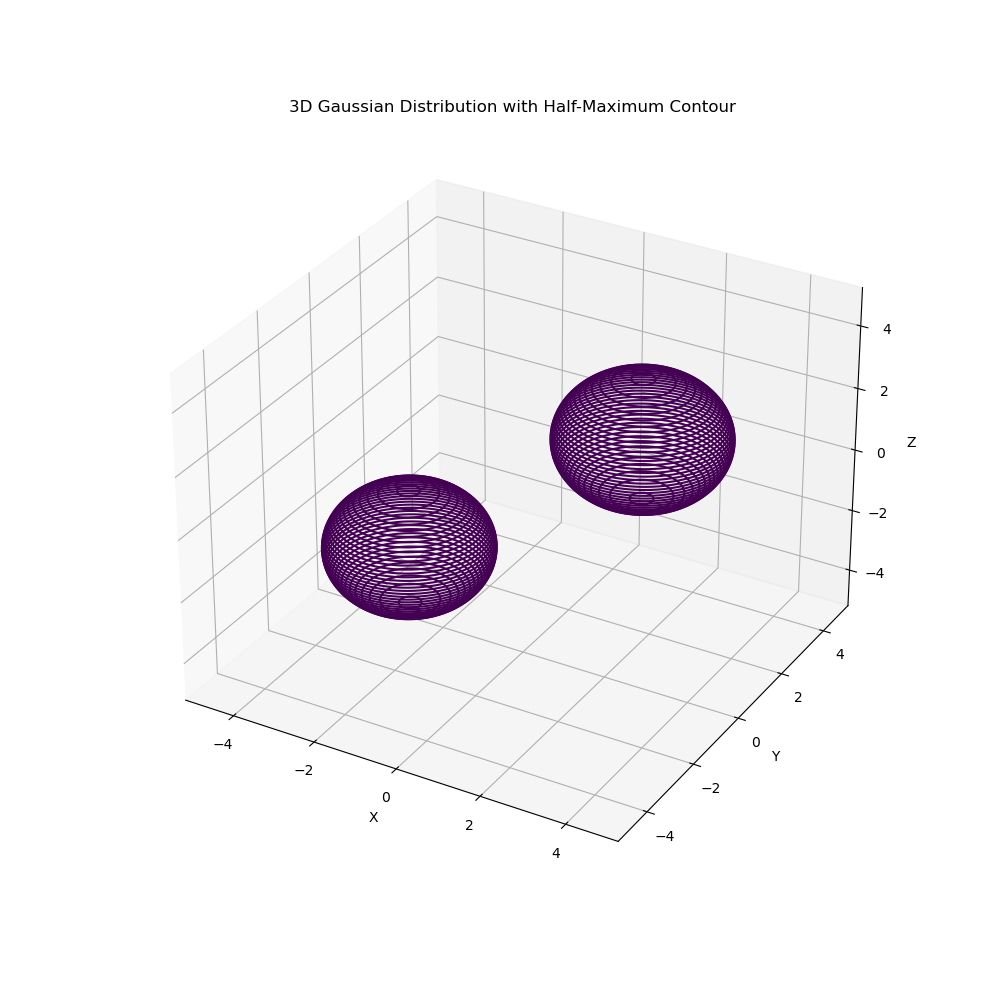

In [3]:
%matplotlib ipympl
from mayavi import mlab
#%matplotlib widget
#3D Heatmap in Python using matplotlib 
def plot_3d_quadrature_gaussian_filter_with_contour(scale, orientation, elevation, space=np.linspace(-5, 5, num=20),ax=None):

    if(ax==None):
        # Create the plot
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
    
    # Setup space progression
    xs, ys, zs = np.meshgrid(space, space, space)
    
    filter_re, filter_im = quadrature_gaussian_filter_3d(xs, ys, zs, scale, orientation, elevation, norm=True, separate_pairs=True)
    
    filter_amplitude_re = np.abs(filter_re)
    filter_amplitude_im = np.abs(filter_im)
    
    max_amplitude = np.max((filter_amplitude_re,filter_amplitude_im))

    # Plot the real part as contours
    for z in range(len(space)):
        ax.contour(xs[:, :, z], ys[:, :, z], filter_amplitude_re[:, :, z], levels=[max_amplitude / 2], zdir='z', offset=space[z])

    # Plot the imaginary part as contours
    for z in range(len(space)):
        ax.contour(xs[:, :, z], ys[:, :, z], filter_amplitude_im[:, :, z], levels=[max_amplitude / 2], zdir='z', offset=space[z])
    
    return(ax)

scale = 4
orientation = 0
elevation = pi/4

xyzspace = np.linspace(-5, 5, num=100)
ax = plot_3d_quadrature_gaussian_filter_with_contour(scale, orientation, elevation, space=xyzspace)
# Set axis limits based on space
ax.set_xlim(np.min(xyzspace), np.max(xyzspace))
ax.set_ylim(np.min(xyzspace), np.max(xyzspace))
ax.set_zlim(np.min(xyzspace), np.max(xyzspace))

# Additional plot settings
ax.set_title('3D Gaussian Distribution with Half-Maximum Contour')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

## Go through a range of scales and orientations and plot them all

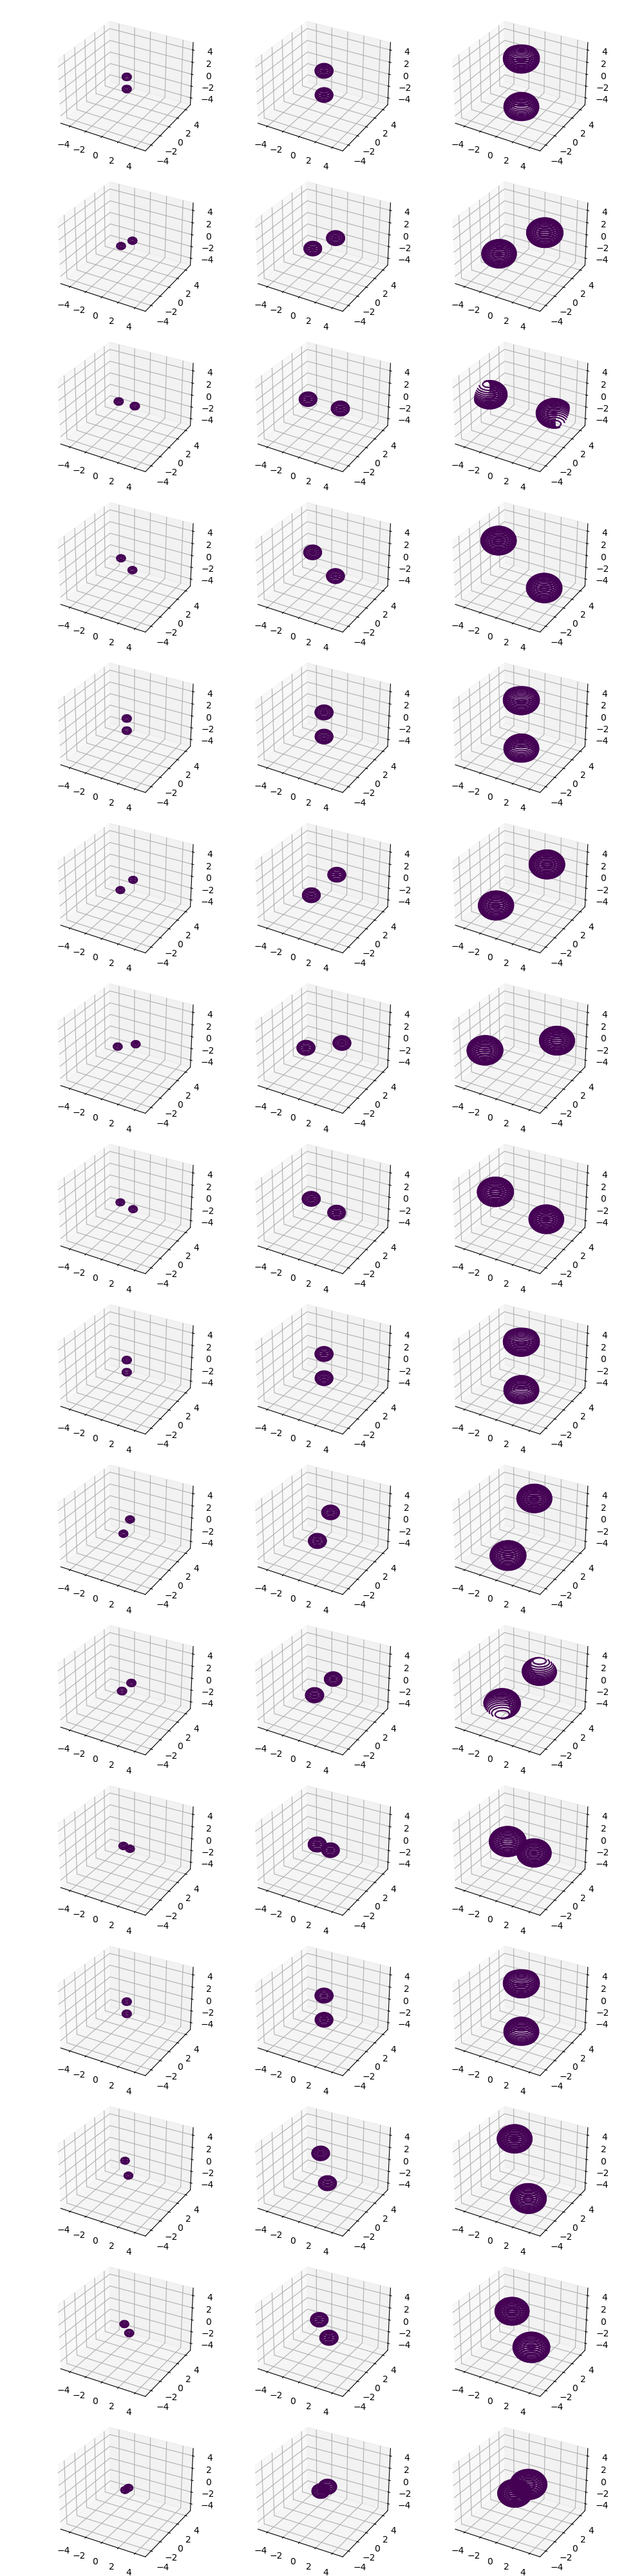

In [11]:
#pick our scales & centers
scales = [1,2,4]
orientations = [0,pi/4,pi/2,3*pi/4]
elevations = [0,pi/4,pi/2,3*pi/4]
#setup space and time progression
xyzspace = np.linspace(-5,5, num=50)

# Create the figure
fig, axs = plt.subplots(len(orientations) * len(elevations), len(scales), figsize=(10, 40), subplot_kw={'projection': '3d'})

for i, orientation in enumerate(orientations):
    for j, elevation in enumerate(elevations):
        for k, scale in enumerate(scales):
            ax = axs[i * len(elevations) + j, k]
            plot_3d_quadrature_gaussian_filter_with_contour(scale, orientation, elevation, space=xyzspace, ax=ax)
            ax.set_xlim(np.min(xyzspace), np.max(xyzspace))
            ax.set_ylim(np.min(xyzspace), np.max(xyzspace))
            ax.set_zlim(np.min(xyzspace), np.max(xyzspace))
plt.tight_layout()
plt.show()


## Plot them all on the same axis to see if this makes sense

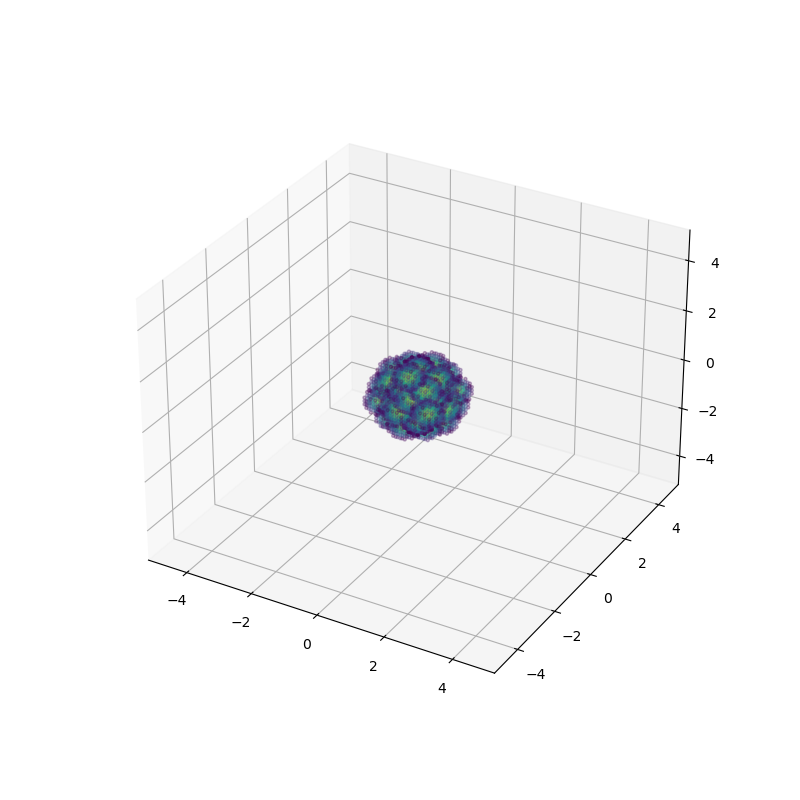

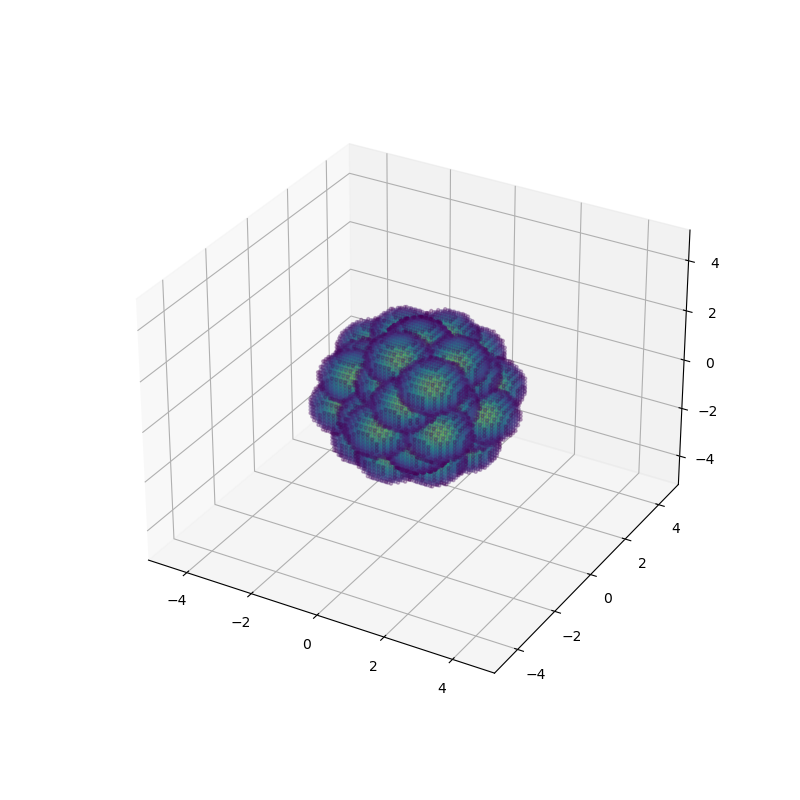

/var/folders/9z/x46c0l7s2_70nc4mttp9z7d80000gn/T/ipykernel_31846/1489589800.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 8))


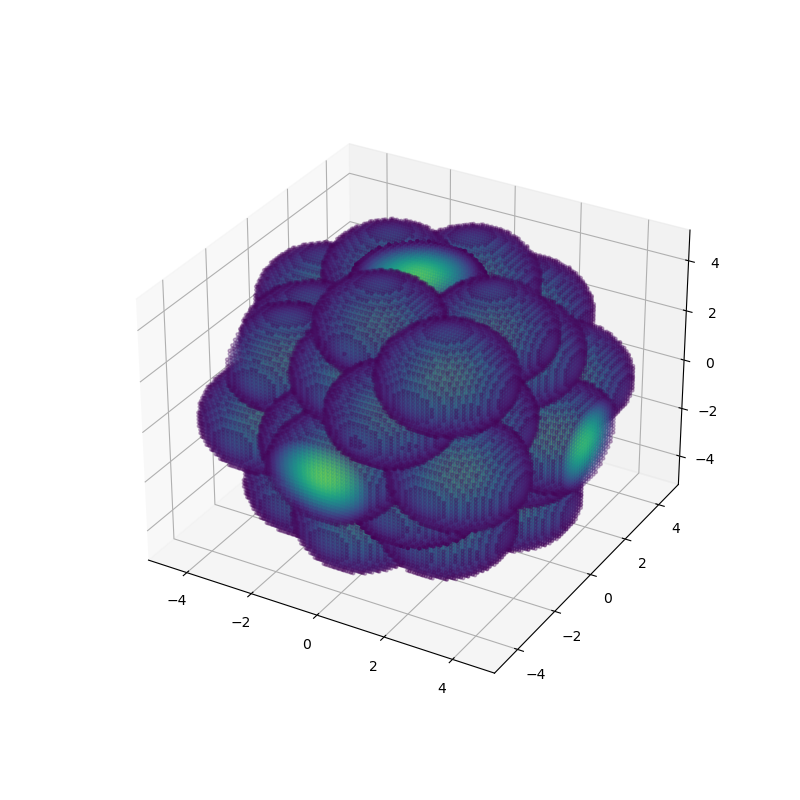

In [10]:
def create_filter_mesh(scale,orientation,elevation,space=np.linspace(-5,5,num=50)):
    xs, ys, zs = np.meshgrid(space, space, space)
    filter = quadrature_gaussian_filter_3d(xs, ys, zs, scale, orientation, elevation, norm=False, separate_pairs=False)
    filter_amplitude = np.abs(filter)
    max_amplitude = np.max(filter_amplitude)
    keep_mask = np.where(filter_amplitude > (max_amplitude/2))    
    xs = xs[keep_mask]
    ys = ys[keep_mask]
    zs = zs[keep_mask]
    filter_amplitude = filter_amplitude[keep_mask]
    return(xs,ys,zs,filter_amplitude)

#pick our scales & centers
scales = [1,2,4]
orientations = [0,pi/4,pi/2,3*pi/4]
elevations = [0,pi/4,pi/2,3*pi/4]

#all on one plot
#fig = plt.figure(figsize=(12, 8))
#ax = fig.add_subplot(111, projection='3d')
xyzspace = np.linspace(-5,5, num=75)

for k, scale in enumerate(scales):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for i, orientation in enumerate(orientations):
        for j, elevation in enumerate(elevations):
            xs,ys,zs,amps = create_filter_mesh(scale,orientation,elevation,space=xyzspace)
            ax.scatter(xs,ys,zs,c=amps,cmap='viridis',marker='.',alpha=0.3)

    ax.set_xlim(np.min(xyzspace), np.max(xyzspace))
    ax.set_ylim(np.min(xyzspace), np.max(xyzspace))
    ax.set_zlim(np.min(xyzspace), np.max(xyzspace))
    plt.show()


## How do these look in space/time filter domain?
These filters were created in the fourier domain, what do they look lik in the spatial domain?

In [ ]:
# #demo one
# def inverse_power_spec(filter):
#     #complex_spec = ampspec * np.exp(1j * np.zeros_like(ampspec))
#     filter = np.fft.ifft2(np.fft.ifftshift(filter)) #unshift 
#     filter = np.fft.fftshift(filter)
#     filter_real = np.real(filter) #real pair filter
#     filter_imag = np.imag(filter) #imag pair filter
#     return(filter_real,filter_imag)

# #c/o chatgpt
# def check_fourier_symmetry(F):
#     # Check if the Fourier transform F has Hermitian symmetry
#     # F should be a 2D array
#     return np.allclose(F, np.conj(np.flipud(np.fliplr(F))))

# n = 128
# space = np.linspace(-30,30,num=n)
# time = np.linspace(-30,30,num=n)
# xs,ys = np.meshgrid(space,time)

# scale=3
# orientation=0
# fourier_filter = quadrature_gaussian_filter(xs,ys,scale,orientation,norm=True)


# # Check symmetry
# symmetric = check_fourier_symmetry(np.abs(fourier_filter))
# print(f"Fourier filter is symmetric: {symmetric}")

# scale = 1
# orientation=np.pi/2
# plt.pcolormesh(space, time, np.abs(fourier_filter))
# plt.axhline(0,color='red') # x = 0
# plt.axvline(0,color='red') # y = 0
# plt.title('Fourier Extent')
# plt.colorbar()
# plt.show()

# filter_real, filter_imag = inverse_power_spec(fourier_filter)
# plt.pcolormesh(space, time, filter_real)
# plt.axhline(0,color='red') # x = 0
# plt.axvline(0,color='red') # y = 0
# plt.title('Real Filter')
# plt.colorbar()
# plt.show()

# plt.pcolormesh(space, time, filter_imag)
# plt.axhline(0,color='red') # x = 0
# plt.axvline(0,color='red') # y = 0
# plt.title('Imaginary Filter')
# plt.colorbar()
# plt.show()


# plt.pcolormesh(space, time, filter_real - filter_imag)
# plt.axhline(0,color='red') # x = 0
# plt.axvline(0,color='red') # y = 0
# plt.title('difference')
# plt.colorbar()
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming definitions for pol2cart, gauss_filter_2d are available and correct

# def check_fourier_symmetry(F):
#     # Check if the Fourier transform F has Hermitian symmetry
#     # F should be a 2D array
#     return np.allclose(F, np.conj(np.flipud(np.fliplr(F))))

# def test_filter():
#     # Grid setup
#     space = np.linspace(-10, 10, num=128)
#     time = np.linspace(-10, 10, num=128)
#     xs, ys = np.meshgrid(space, time)

#     # Filter parameters
#     scale = 2
#     orientation = np.pi/4  #np.pi / 4  # 45 degrees

#     # Generate filter in Fourier space
#     fourier_filter = quadrature_gaussian_filter(xs, ys, scale, orientation)

#     # Check symmetry
#     symmetric = check_fourier_symmetry(np.abs(fourier_filter))
#     print(f"Fourier filter is symmetric: {symmetric}")
    
#     # Transform to spatial domain
#     filter_real, filter_imag = inverse_power_spec(fourier_filter)
#     #spatial_filter = np.fft.ifft2(np.fft.ifftshift(fourier_filter))
#     #spatial_filter = np.fft.fftshift(spatial_filter)
#     #filter_real = np.real(spatial_filter)
#     #filter_imag = np.imag(spatial_filter)

#     # Plot results
#     plt.figure(figsize=(12, 5))
#     plt.subplot(121)
#     plt.imshow(filter_real, extent=(space.min(), space.max(), time.min(), time.max()))
#     plt.axhline(0,color='red') # x = 0
#     plt.axvline(0,color='red') # y = 0
#     plt.title('Real Part of Spatial Filter')
#     plt.colorbar()

#     plt.subplot(122)
#     plt.imshow(filter_imag, extent=(space.min(), space.max(), time.min(), time.max()))
#     plt.axhline(0,color='red') # x = 0
#     plt.axvline(0,color='red') # y = 0
#     plt.title('Imaginary Part of Spatial Filter')
#     plt.colorbar()

#     plt.show()

# test_filter()

In [ ]:
# #pick our scales & centers
# scales = [2,4,8,16]
# orientations = [0,pi/4,pi/2,3*pi/4]
# space = np.linspace(-30,30,num=256)
# time = np.linspace(-30,30,num=256)
# xs,ys = np.meshgrid(space,time)

# #plot these all
# fig,ax = plt.subplots(figsize=(15,15))
# for i, orientation in enumerate(orientations):
#     for j, scale in enumerate(scales):
#         #create filter
#         fourier_footprint = quadrature_gaussian_filter(xs,ys,scale,orientation)
#         filter_real, filter_imag = inverse_power_spec(fourier_footprint)
#         filter_pair = np.concatenate((filter_real, filter_imag), axis=0)
#         #plot it
#         plt.subplot(len(orientations),len(scales),i*len(scales)+j+1, aspect=0.5)
#         plt.pcolormesh(filter_pair)
#         plt.colorbar()
#         #plt.pcolormesh(space, time, filter, cmap='Greys_r')
#         #plt.contour(xs, ys, filter, levels=[np.max(filter) / 2], colors='red', linestyles='-', linewidths=2)
#         #plt.pcolormesh(space, time, filter, shading='auto',cmap='Greys_r')
#         #plt.fill_between(x, y, where=((x > half_max_x1) & (x < half_max_x2)), color='gray', alpha=0.5, label='FWHM Area')
#         #plt.axvline(half_max_x1, color='b', linestyle='--', label='FWHM Boundaries')
#         plt.xlabel('Space (pixels)')
#         plt.ylabel('Time (real filter top; imag filter bottom)')
#         #plt.colorbar()
#         plt.tight_layout()
